In [1]:
# Install required packages in the current Jupyter kernel
# Uncomment the following lines if you need to install these libraries
# If you run into permission issues, try with the --user option
# import sys
# !pip install -q rdflib networkx matplotlib
# !{sys.executable} -m pip install rdflib networkx matplotlib --user
# Imports
from rdflib import Graph as RDFGraph
from rdflib.extras.external_graph_libs import rdflib_to_networkx_graph
import networkx as nx
from networkx import Graph as NXGraph
import matplotlib.pyplot as plt
import statistics
import collections

In [ ]:
datapath = '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/STRING/rdf/protein.links.rdf.v11.5/402676.protein.links.rdf.v11.5.txt.gz'
# RDF graph loading
import gzip
from rdflib.namespace import RDF
with gzip.open(datapath,'rb') as inputdata:
    rg = RDFGraph()
    rg.parse(inputdata.read(), format='turtle')
    print("rdflib Graph loaded successfully with {} triples".format(len(rg)))

In [13]:
import networkx as nx
import pandas as pd
humandf = pd.read_csv( '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/STRING/human/9606.protein.links.v11.5.txt.gz' , sep = "\s" , compression = 'infer' )
print(humandf.columns)

Index(['protein1', 'protein2', 'combined_score'], dtype='object')


In [ ]:
G=nx.from_pandas_edgelist(humandf, source='protein1', target='protein2') #)['combined_score'])

(array([6183.,  288.,  255.,  156.,  150.,  221.,  121.,  103.,   21.,
          10.]),
 array([ 0. ,  3.4,  6.8, 10.2, 13.6, 17. , 20.4, 23.8, 27.2, 30.6, 34. ]),
 <BarContainer object of 10 artists>)

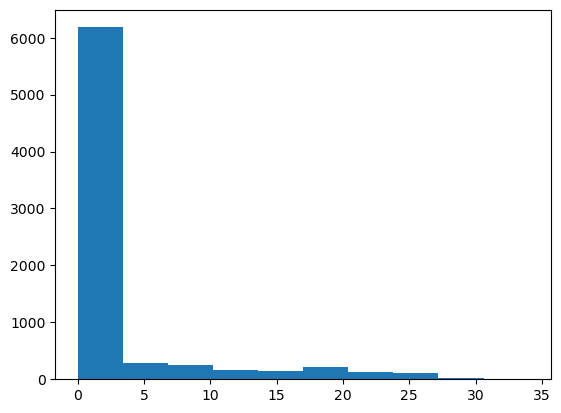

In [16]:
plt.hist(nx.degree_histogram(G))

In [3]:
preds = rg.predicates(subject=None, object=None, unique=True)
preds = [ p for  p in preds]
print(preds)

[rdflib.term.URIRef('https://string-db.org/rdf/any-confidence'), rdflib.term.URIRef('https://string-db.org/rdf/high-confidence-cutoff'), rdflib.term.URIRef('https://string-db.org/rdf/medium-confidence-cutoff'), rdflib.term.URIRef('https://string-db.org/rdf/highest-confidence-cutoff')]


In [18]:
#get a subject and expand
import random
#recursive function to get some neighbours
def grab_neighbours(seed,rg, limit = 10, recur = 0 , maxrecur = 3 , sample_run = 100 ):
    nodes = []
    #sample the neighbourhood randomly
    objs =  rg.objects(subject = seed ) 
    objs = [  next(objs) for i in range(sample_run) ]
    random.shuffle(objs)
    for i,obj in enumerate(objs):
        if i < limit and recur < maxrecur:
            nodes += grab_neighbours(obj,rg,limit = limit, recur = recur+1 )    
        elif i < limit:
            nodes.append( obj )
        if i > limit:
            break
    return nodes

def sample( subject_iter = None , seed = None, layers = 3 , layer_limit = 3 , verbose = True):
    if not seed:
        seed = next(subject_iter)
    if verbose == True:
        print('seed', seed)
    nodes = grab_neighbours(seed,rg, limit = layer_limit, recur = 0 , maxrecur = layers)
    subG = RDFGraph()
    triples = [ rg.triples((n1,None,n2)) for n1 in nodes for n2 in nodes if n1 != n2 ]
    for t in triples:
        subG+=t
    return subG
    


In [19]:
import rdflib
subjs = rg.subjects( unique = True)
subg = sample(subject_iter = subjs , layer_limit= 2)
print(subg)
G = rdflib.extras.external_graph_libs.rdflib_to_networkx_multidigraph( subg , lambda s, p, o: {'data':{'key':p  , 'weight':1} } )

seed https://string-db.org/network/402676.B6K7N9
[a rdfg:Graph;rdflib:storage [a rdflib:Store;rdfs:label 'Memory']].


In [20]:
print([e for i,e in enumerate(G.edges(data = True , keys=True)) if i < 10])

[(rdflib.term.URIRef('https://string-db.org/network/402676.B6K5N0'), rdflib.term.URIRef('https://string-db.org/network/402676.B6K0G5'), 0, {'data': {'key': rdflib.term.URIRef('https://string-db.org/rdf/medium-confidence-cutoff'), 'weight': 1}}), (rdflib.term.URIRef('https://string-db.org/network/402676.B6K5N0'), rdflib.term.URIRef('https://string-db.org/network/402676.B6K0G5'), 1, {'data': {'key': rdflib.term.URIRef('https://string-db.org/rdf/any-confidence'), 'weight': 1}}), (rdflib.term.URIRef('https://string-db.org/network/402676.B6K5N0'), rdflib.term.URIRef('https://string-db.org/network/402676.B6K2B4'), 0, {'data': {'key': rdflib.term.URIRef('https://string-db.org/rdf/medium-confidence-cutoff'), 'weight': 1}}), (rdflib.term.URIRef('https://string-db.org/network/402676.B6K5N0'), rdflib.term.URIRef('https://string-db.org/network/402676.B6K2B4'), 1, {'data': {'key': rdflib.term.URIRef('https://string-db.org/rdf/high-confidence-cutoff'), 'weight': 1}}), (rdflib.term.URIRef('https://st

In [21]:
import colour
import itertools

red = colour.Color('red')
blue = colour.Color('blue')

c = [ c.hex_l for c in  list(red.range_to(blue, len(preds))) ]
colors = { p:c[i] for i,p in enumerate(preds)}
delta = 2/len(preds)
curve = { p:delta*i for i,p in enumerate(preds) }
style = itertools.cycle([ '-', '--' ])
line_style = { p:next(style) for p in preds }

In [22]:
print(colors)

{rdflib.term.URIRef('https://string-db.org/rdf/any-confidence'): '#ff0000', rdflib.term.URIRef('https://string-db.org/rdf/high-confidence-cutoff'): '#aaff00', rdflib.term.URIRef('https://string-db.org/rdf/medium-confidence-cutoff'): '#00ffaa', rdflib.term.URIRef('https://string-db.org/rdf/highest-confidence-cutoff'): '#0000ff'}


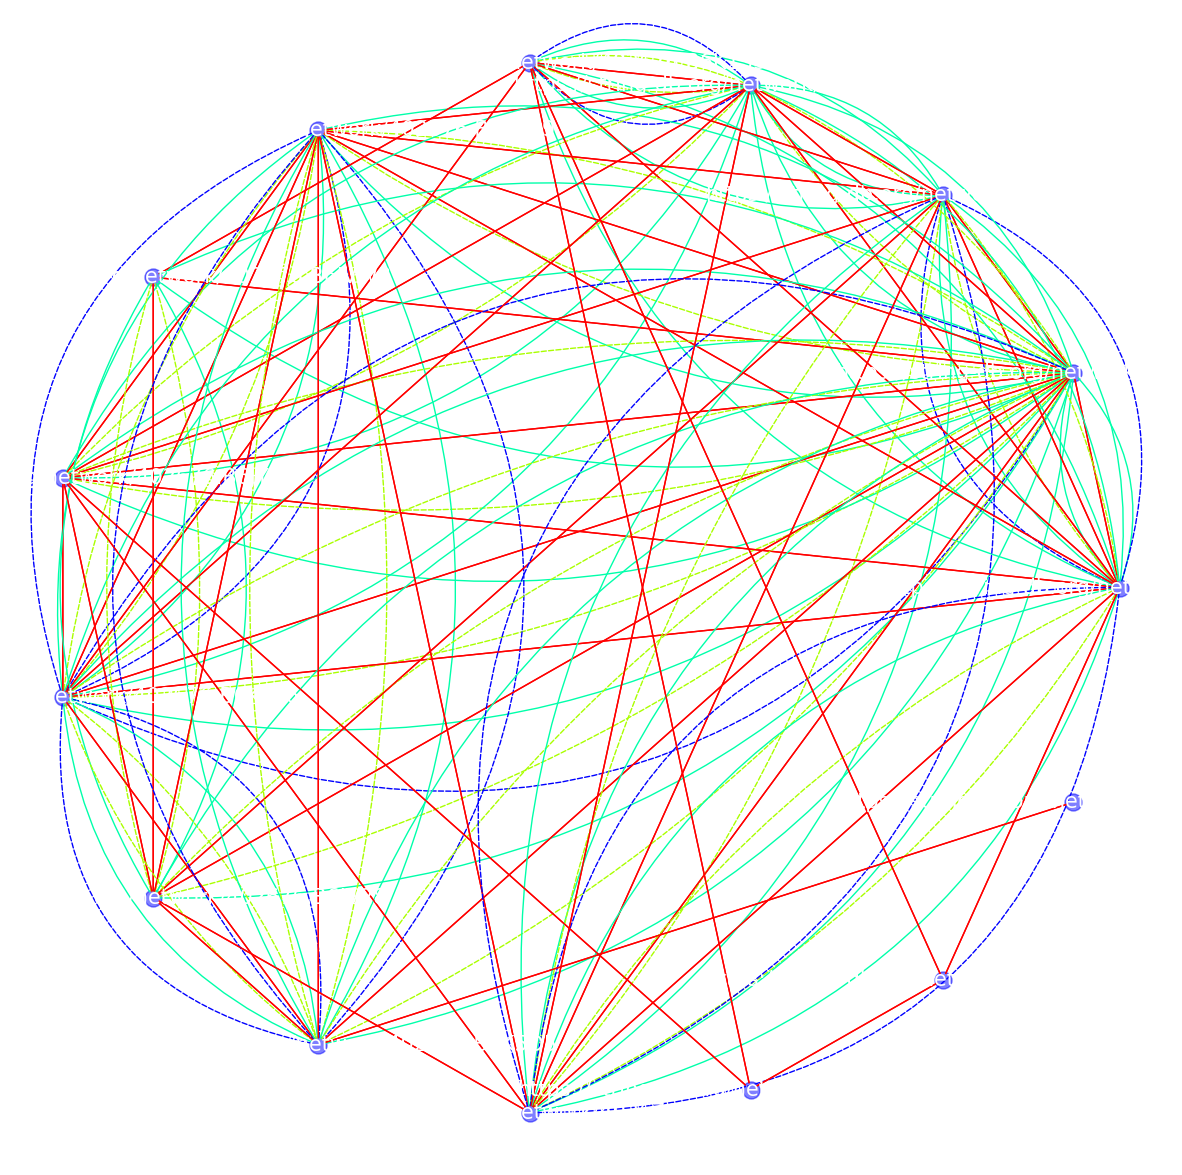

In [23]:

pos = nx.circular_layout( G )

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(15)
plt.plot()

#plot the whole mess
ax = plt.gca()

for e in G.edges(data = True):
    ax.annotate("",
                xy=pos[e[0]], xycoords='data',
                xytext=pos[e[1]], textcoords='data',
                arrowprops=dict(arrowstyle="-", color=colors[e[2]['data']['key']],
                                shrinkA=5, shrinkB=5, lw = e[2]['data']['weight'], ls = line_style[e[2]['data']['key']],
                                patchA=None, patchB=None, alpha = e[2]['data']['weight'],
                                connectionstyle="arc3,rad=rrr".replace('rrr',str(0.3*curve[e[2]['data']['key']])
                                ),
                                ),
                )

nx.draw_networkx_nodes(G, pos, node_color = 'b', node_size = 150, alpha = .5)
labels=nx.draw_networkx_labels(G , pos = pos , font_size= 15 , font_color='w')

plt.axis('off')
plt.show()


In [24]:
import gzip
omadata = '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/OMA/rdf/oma_hogs_rdf_0.ttl.gz'
with gzip.open(omadata,'rb') as inputdata:
    
    OMArg = RDFGraph()
    OMArg.parse(inputdata.read(), format='turtle')
    print("rdflib Graph loaded successfully with {} triples".format(len(OMArg)))
    

rdflib Graph loaded successfully with 9325503 triples


In [25]:
preds = OMArg.predicates(subject=None, object=None, unique=True)
preds = [ p for  p in preds]
print(preds)

[rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#seeAlso'), rdflib.term.URIRef('http://purl.org/dc/terms/identifier'), rdflib.term.URIRef('http://purl.obolibrary.org/obo/RO_0001018'), rdflib.term.URIRef('http://purl.org/net/orth#organism'), rdflib.term.URIRef('http://purl.org/net/orth#hasHomologousMember'), rdflib.term.URIRef('http://purl.obolibrary.org/obo/CDAO_0000148'), rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'), rdflib.term.URIRef('http://purl.org/net/orth#inDataset'), rdflib.term.URIRef('http://purl.org/net/orth#hasTaxonomicRange'), rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#label'), rdflib.term.URIRef('http://purl.org/net/orth#taxRange'), rdflib.term.URIRef('http://purl.uniprot.org/core/rank'), rdflib.term.URIRef('http://purl.org/net/orth#taxRangeId'), rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#comment'), rdflib.term.URIRef('http://purl.obolibrary.org/obo/RO_0002162'), rdflib.term.URIRef('http://purl.org/pav/version'

In [26]:
omadata = '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/OMA/rdf/xref_desc.ttl.gz'
with gzip.open(omadata,'rb') as inputdata:
    XREFrg = RDFGraph()
    XREFrg.parse(inputdata.read(), format='turtle')
    print("rdflib Graph loaded successfully with {} triples".format(len(XREFrg)))

rdflib Graph loaded successfully with 17287741 triples


In [27]:
#query for hogs here


#check bloom filters for interactors in diff species


#construct networkx graph of the whole subnetwork across species with phylo links for hog



rdflib Graph loaded successfully with 17287741 triples
rdflib Graph loaded successfully with 17287741 triples
rdflib Graph loaded successfully with 17287741 triples
rdflib Graph loaded successfully with 17287741 triples
rdflib Graph loaded successfully with 17287741 triples
rdflib Graph loaded successfully with 17287741 triples
rdflib Graph loaded successfully with 17287741 triples
rdflib Graph loaded successfully with 17287741 triples
rdflib Graph loaded successfully with 17287741 triples
rdflib Graph loaded successfully with 17287741 triples
rdflib Graph loaded successfully with 17287741 triples
rdflib Graph loaded successfully with 17287741 triples
rdflib Graph loaded successfully with 17287741 triples
rdflib Graph loaded successfully with 17287741 triples
rdflib Graph loaded successfully with 17287741 triples
rdflib Graph loaded successfully with 17287741 triples
rdflib Graph loaded successfully with 17287741 triples
rdflib Graph loaded successfully with 17287741 triples
rdflib Gra

In [28]:
preds = XREFrg.predicates(subject=None, object=None, unique=True)
preds = [ p for  p in preds]
print(preds)

[rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#comment')]


In [15]:
import pickle 
import glob

filters = './filters/bloomfinal_big*.pkl'
filters = glob.glob(filters)
filters = [ pickle.load(open(f, 'rb')) for f in filters ]
print(filters)

[[(BloomFilter(ideal_num_elements_n=100000000, error_rate_p=0.001000, num_bits_m=1437758757), 76358434)], [(BloomFilter(ideal_num_elements_n=100000000, error_rate_p=0.001000, num_bits_m=1437758757), 80606663)], [(BloomFilter(ideal_num_elements_n=100000000, error_rate_p=0.001000, num_bits_m=1437758757), 71174921)], [(BloomFilter(ideal_num_elements_n=100000000, error_rate_p=0.001000, num_bits_m=1437758757), 77390257)], [(BloomFilter(ideal_num_elements_n=100000000, error_rate_p=0.001000, num_bits_m=1437758757), 70656044)], [(BloomFilter(ideal_num_elements_n=100000000, error_rate_p=0.001000, num_bits_m=1437758757), 78053087)], [(BloomFilter(ideal_num_elements_n=100000000, error_rate_p=0.001000, num_bits_m=1437758757), 69379149)], [(BloomFilter(ideal_num_elements_n=100000000, error_rate_p=0.001000, num_bits_m=1437758757), 63716625)], [(BloomFilter(ideal_num_elements_n=100000000, error_rate_p=0.001000, num_bits_m=1437758757), 75075008)], [(BloomFilter(ideal_num_elements_n=100000000, error_ra

In [16]:
def check_filters(val,filters = filters):
    for f in filters:
        if val in f[0]:
            return True
    return False
print(check_filters('crap'))
print(check_filters('23.BEL05_00185 _23.BEL05_00025 '.encode()))
print(check_filters('23.BEL05_00045 23.BEL05_02665'))

False
False
False


In [17]:
import dask
from dask.distributed import fire_and_forget
from dask.distributed import Client, Variable , Queue , Lock ,LocalCluster
from dask_jobqueue import SLURMCluster
from dask.distributed import  utils_perf
from dask.distributed import Client, LocalCluster
import dask
import redis
from bloom_filter2 import BloomFilter
import lzma
from dask import dataframe as dd
path = '/work/FAC/FBM/DBC/cdessim2/default/dmoi/'
link_df = dd.read_csv(path + 'datasets/STRING/protein.links.full.v11.5.txt',  blocksize=15e6 , header = 0, sep = ' ')
print(link_df)
sampledf = link_df.sample(frac = .0000000001).compute()
print(sampledf)

Dask DataFrame Structure:
                   protein1 protein2 neighborhood neighborhood_transferred fusion cooccurence homology coexpression coexpression_transferred experiments experiments_transferred database database_transferred textmining textmining_transferred combined_score
npartitions=102701                                                                                                                                                                                                                                             
                     object   object        int64                    int64  int64       int64    int64        int64                    int64       int64                   int64    int64                int64      int64                  int64          int64
                        ...      ...          ...                      ...    ...         ...      ...          ...                      ...         ...                     ...      ...                  ...

/work/FAC/FBM/DBC/cdessim2/default/dmoi/miniconda3/envs/ML2/lib/python3.10/site-packages/dask/dataframe/io/csv.py:129: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  df = pandas_read_text(

KeyboardInterrupt



In [18]:
sample = 1000
data ={}
import pandas as pd
path = '/work/FAC/FBM/DBC/cdessim2/default/dmoi/'
with open(path + 'datasets/STRING/protein.links.full.v11.5.txt' ) as stringlinks:
    for i,line in enumerate( stringlinks):
        if i > sample:
            break
        if i > 0:
            data[i]= {j:w for j,w in enumerate(line.split())}
sampledf = pd.DataFrame.from_dict(data, orient = 'index')
print(sampledf)

                  0               1  2  3  4    5  6  7    8  9  10 11 12 13  \
1     23.BEL05_00185  23.BEL05_00025  0  0  0  169  0  0    0  0  0  0  0  0   
2     23.BEL05_00025  23.BEL05_00390  0  0  0  155  0  0    0  0  0  0  0  0   
3     23.BEL05_00390  23.BEL05_00025  0  0  0  155  0  0    0  0  0  0  0  0   
4     23.BEL05_00025  23.BEL05_00435  0  0  0  196  0  0  174  0  0  0  0  0   
5     23.BEL05_00435  23.BEL05_00025  0  0  0  196  0  0  174  0  0  0  0  0   
...              ...             ... .. .. ..  ... .. ..  ... .. .. .. .. ..   
996   23.BEL05_00035  23.BEL05_01175  0  0  0  150  0  0    0  0  0  0  0  0   
997   23.BEL05_01175  23.BEL05_00035  0  0  0  150  0  0    0  0  0  0  0  0   
998   23.BEL05_00035  23.BEL05_01195  0  0  0    0  0  0    0  0  0  0  0  0   
999   23.BEL05_01195  23.BEL05_00035  0  0  0    0  0  0    0  0  0  0  0  0   
1000  23.BEL05_00035  23.BEL05_01235  0  0  0  154  0  0    0  0  0  0  0  0   

       14   15  
1       0  169  
2    

In [19]:
def add_links(df):
    df = df[~df[0].isna()]
    df = df[~df[1].isna()]
    df.protein1 = df[0].map(lambda x:str(x))
    df.protein2 = df[1].map(lambda x:str(x))
    df['protlinks'] = df[0] + '_' + df[1] 
    return df
sampledf = add_links(sampledf)
print(sampledf)

                   0               1  2  3  4    5  6  7    8  9 10 11 12 13  \
1     23.BEL05_00185  23.BEL05_00025  0  0  0  169  0  0    0  0  0  0  0  0   
2     23.BEL05_00025  23.BEL05_00390  0  0  0  155  0  0    0  0  0  0  0  0   
3     23.BEL05_00390  23.BEL05_00025  0  0  0  155  0  0    0  0  0  0  0  0   
4     23.BEL05_00025  23.BEL05_00435  0  0  0  196  0  0  174  0  0  0  0  0   
5     23.BEL05_00435  23.BEL05_00025  0  0  0  196  0  0  174  0  0  0  0  0   
...              ...             ... .. .. ..  ... .. ..  ... .. .. .. .. ..   
996   23.BEL05_00035  23.BEL05_01175  0  0  0  150  0  0    0  0  0  0  0  0   
997   23.BEL05_01175  23.BEL05_00035  0  0  0  150  0  0    0  0  0  0  0  0   
998   23.BEL05_00035  23.BEL05_01195  0  0  0    0  0  0    0  0  0  0  0  0   
999   23.BEL05_01195  23.BEL05_00035  0  0  0    0  0  0    0  0  0  0  0  0   
1000  23.BEL05_00035  23.BEL05_01235  0  0  0  154  0  0    0  0  0  0  0  0   

       14   15                      pro

/tmp/25549704/ipykernel_2112516/3218239898.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.protein1 = df[0].map(lambda x:str(x))
/tmp/25549704/ipykernel_2112516/3218239898.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.protein2 = df[1].map(lambda x:str(x))


In [21]:
#check sampledf in filters
sampledf['check'] = sampledf.protlinks.map( lambda x : 1 if check_filters(x) == True else 0 )
print(sampledf.check.sum())

0


In [29]:


#sample string subnet

#get OMA HOGs

#jump to a few close species 

#

#collapse nodes with degree 2


In [30]:
i = 0 
from rdflib.namespace import RDF

for s, p, o in rg.triples((None,  RDF.type, None)):
    print(f"{s} is a {o}")
    if i > 10:
        break

In [ ]:
#map string neighbours to OMA entries

#jump a few steps in HOGs

#fish for STRING interactions in other species


